In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
%env CUDA_DEVICE_ORDER=PCI_BUS_ID
%env CUDA_VISIBLE_DEVICES=3

env: CUDA_DEVICE_ORDER=PCI_BUS_ID
env: CUDA_VISIBLE_DEVICES=3


In [3]:
from avgn.utils.paths import DATA_DIR, most_recent_subdirectory, ensure_dir
from avgn.tensorflow.data import _parse_function

/mnt/cube/tsainbur/conda_envs/tpy3/lib/python3.6/site-packages/tqdm/autonotebook/__init__.py:14: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  " (e.g. in jupyter console)", TqdmExperimentalWarning)


In [4]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from tqdm.autonotebook import tqdm
%matplotlib inline
from IPython import display
import pandas as pd

# the nightly build of tensorflow_probability is required as of the time of writing this 
import tensorflow_probability as tfp
ds = tfp.distributions

In [5]:
print(tf.__version__, tfp.__version__)

2.0.0-beta1 0.7.0-dev20190510


In [6]:
TRAIN_SIZE=101726
BATCH_SIZE=128
TEST_SIZE=10000
DIMS = (128, 128, 1)
N_TRAIN_BATCHES =int((TRAIN_SIZE-TEST_SIZE)/BATCH_SIZE)
N_TEST_BATCHES = int(TEST_SIZE/BATCH_SIZE)
TRAIN_BUF = 1000
TEST_BUF = 1000

In [7]:
record_loc = DATA_DIR / 'tfrecords' / "starling.tfrecords"

In [8]:
# read the dataset
raw_dataset = tf.data.TFRecordDataset([record_loc.as_posix()])

In [9]:
data_types = {
    "spectrogram": tf.uint8,
    "index": tf.int64,
    "indv": tf.string,
}

In [10]:
# parse each data type to the raw dataset
dataset = raw_dataset.map(lambda x: _parse_function(x, data_types=data_types))

In [11]:
spec, index, indv  = next(iter(dataset))

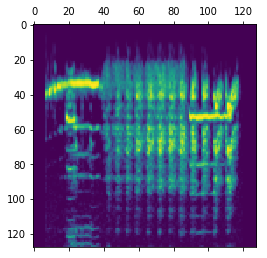

In [12]:
plt.matshow(spec.numpy().reshape(128,128))

In [49]:
test_dataset = dataset.take(TEST_SIZE).shuffle(TRAIN_BUF).batch(BATCH_SIZE)
train_dataset = dataset.skip(TEST_SIZE).take(TRAIN_SIZE-TEST_SIZE).shuffle(TEST_BUF).batch(BATCH_SIZE)

In [81]:
N_Z = 128

encoder = [
    tf.keras.layers.InputLayer(input_shape=DIMS),
    tf.keras.layers.Conv2D(
        filters=32, kernel_size=3, strides=(2, 2), activation=tf.nn.leaky_relu
    ),
    tf.keras.layers.Conv2D(
        filters=64, kernel_size=3, strides=(2, 2), activation=tf.nn.leaky_relu
    ),
    tf.keras.layers.Conv2D(
        filters=128, kernel_size=3, strides=(2, 2), activation=tf.nn.leaky_relu
    ),
    tf.keras.layers.Conv2D(
        filters=256, kernel_size=3, strides=(2, 2), activation=tf.nn.leaky_relu
    ),
    tf.keras.layers.Conv2D(
        filters=256, kernel_size=3, strides=(2, 2), activation=tf.nn.leaky_relu
    ),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(units=N_Z*2),
]

decoder = [
    tf.keras.layers.Dense(units=4 * 4 * 256, activation=tf.nn.leaky_relu),
    tf.keras.layers.Reshape(target_shape=(4, 4, 256)),
    tf.keras.layers.Conv2DTranspose(
        filters=256, kernel_size=3, strides=(2, 2), padding="SAME", activation=tf.nn.leaky_relu
    ),
    tf.keras.layers.Conv2DTranspose(
        filters=256, kernel_size=3, strides=(2, 2), padding="SAME", activation=tf.nn.leaky_relu
    ),
    tf.keras.layers.Conv2DTranspose(
        filters=128, kernel_size=3, strides=(2, 2), padding="SAME", activation=tf.nn.leaky_relu
    ),
    tf.keras.layers.Conv2DTranspose(
        filters=64, kernel_size=3, strides=(2, 2), padding="SAME", activation=tf.nn.leaky_relu
    ),
    tf.keras.layers.Conv2DTranspose(
        filters=32, kernel_size=3, strides=(2, 2), padding="SAME", activation=tf.nn.leaky_relu
    ),
    tf.keras.layers.Conv2DTranspose(
        filters=1, kernel_size=3, strides=(1, 1), padding="SAME"
    ),
]

In [82]:
from avgn.tensorflow.VAE2 import VAE, plot_reconstruction

In [83]:
# the optimizer for the model
optimizer = tf.keras.optimizers.Adam(1e-4)
# train the model
model = VAE(
    enc = encoder,
    dec = decoder,
    optimizer = optimizer,
    beta = 1.0
)

In [84]:
# exampled data for plotting results
example_data = next(iter(test_dataset))
example_data = (
        tf.cast(tf.reshape(example_data[0], [BATCH_SIZE] + list(DIMS)), tf.float32)
        / 255
)

In [85]:
x= example_data
x_recon = model.reconstruct(x)

In [86]:
np.max(x_recon)

0.50004774

In [87]:
test = x * tf.math.log(1e-5 + x_recon) + (1 - x) * tf.math.log(1e-5 + 1 - x_recon)
np.max(test)

-0.6930677

In [88]:
np.max(x_recon)

0.50004774

In [89]:
model.compute_loss(example_data)

(<tf.Tensor: id=4368, shape=(), dtype=float32, numpy=11364.406>,
 <tf.Tensor: id=4404, shape=(), dtype=float32, numpy=0.0053207874>)

In [90]:
# a pandas dataframe to save the loss information to
losses = pd.DataFrame(columns = ['recon_loss', 'latent_loss'])

In [91]:
N_TRAIN_BATCHES = 100
N_TEST_BATCHES = 15

In [92]:
n_epochs = 500
epoch = 0

In [124]:
def plot_losses(losses):
    cols = list(losses.columns)
    fig, axs = plt.subplots(ncols = len(cols), figsize= (len(cols)*4, 4))
    for ci, col in enumerate(cols):
        if len(cols) == 1:
            ax = axs
        else:
            ax = axs.flatten()[ci]
        ax.loglog(losses[col].values)
        ax.set_title(col)
    plt.show()

Epoch: 434 | recon_loss: 2799.89501953125 | latent_loss: 101.19959259033203


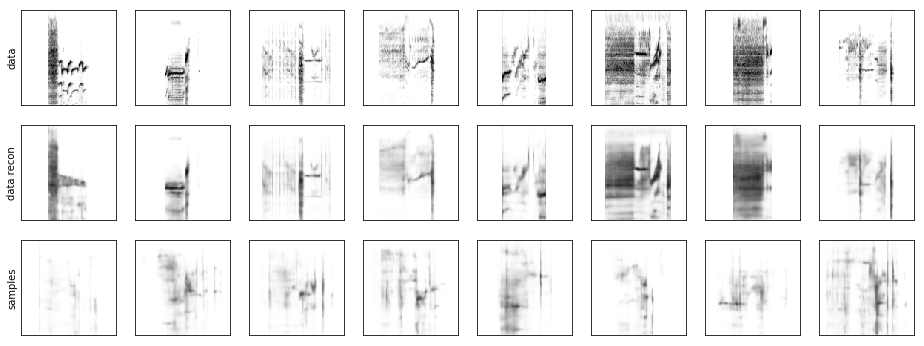

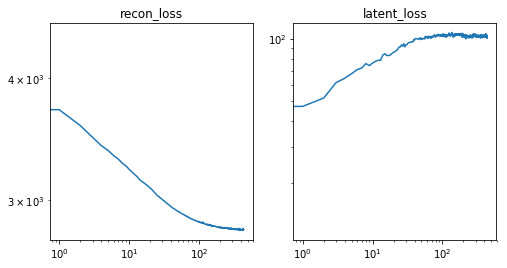

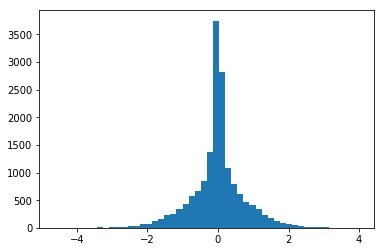

KeyboardInterrupt: 

In [128]:
for epoch in range(epoch, n_epochs):
    # train
    for batch, train_x in tqdm(
        zip(range(N_TRAIN_BATCHES), train_dataset), total=N_TRAIN_BATCHES
    ):
        x = tf.cast(tf.reshape(train_x[0], [BATCH_SIZE] + list(DIMS)), tf.float32) / 255
        model.train_net(x)
    # test on holdout
    loss = []
    for batch, test_x in tqdm(
        zip(range(N_TEST_BATCHES), test_dataset), total=N_TEST_BATCHES
    ):
        x = tf.cast(tf.reshape(test_x[0], [BATCH_SIZE] + list(DIMS)), tf.float32) / 255
        loss.append(model.compute_loss(x))
    losses.loc[len(losses)] = np.mean(loss, axis=0)
    # plot results
    display.clear_output()
    print(
        "Epoch: {} | recon_loss: {} | latent_loss: {}".format(
            epoch, losses.recon_loss.values[-1], losses.latent_loss.values[-1]
        )
    )
    plot_reconstruction(model, example_data, N_Z=N_Z)
    plot_losses(losses)
    
    fig, ax = plt.subplots()
    z = tf.split(model.enc(example_data), num_or_size_splits=2, axis=1)[0].numpy()
    ax.hist(z.flatten(), bins = 50);
    plt.show()

### Save model

In [129]:
DATASET_ID = 'european_starling_gentner_segmented'
network_type = 'VAE'
save_loc = DATA_DIR / 'models' / network_type / (DATASET_ID + '_128')
ensure_dir(save_loc)

# Save the entire model to a HDF5 file.
# The '.h5' extension indicates that the model shuold be saved to HDF5.
model.save_weights((save_loc / (str(epoch).zfill(4))).as_posix()) 

# Recreate the exact same model, including its weights and the optimizer
#new_model = tf.keras.models.load_model('my_model.h5')

### J Diagram

In [112]:
from avgn.visualization.projections import scatter_spec
from avgn.utils.general import save_fig
from avgn.utils.paths import FIGURE_DIR, ensure_dir
ensure_dir(FIGURE_DIR / 'networks' / 'starling128')

In [113]:
gen_func =  model.decode
interp_len = 5

In [114]:
dset_iter = iter(dataset)
x1 = np.reshape(next(dset_iter)[0] / 255, (1,128,128,1))
x2 = np.reshape(next(dset_iter)[0] / 255, (1,128,128,1))
x3 = np.reshape(next(dset_iter)[0] / 255, (1,128,128,1))
exdat = np.vstack([x1, x2, x3])

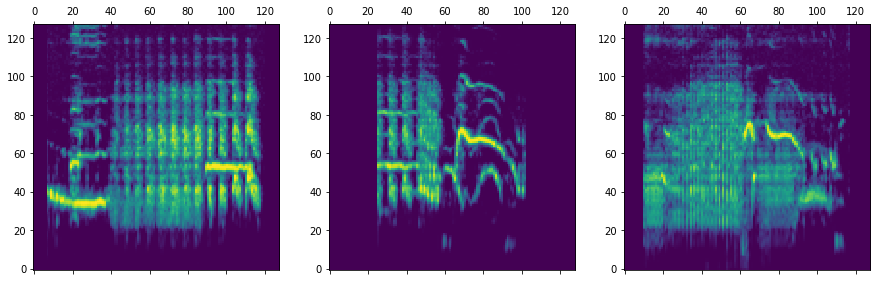

In [115]:
fig, axs = plt.subplots(ncols=3, figsize=(15,5))
axs[0].matshow(np.squeeze(x1), origin='lower')
axs[1].matshow(np.squeeze(x2), origin='lower')
axs[2].matshow(np.squeeze(x3), origin='lower')

In [118]:
(pt1, pt2, pt3), _ = model.encode(exdat)

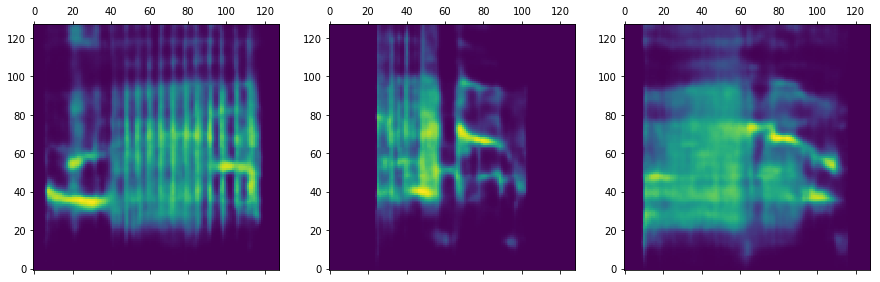

In [119]:
xr1, xr2, xr3 = model.decode(np.vstack([pt1, pt2, pt3]), apply_sigmoid=True)

fig, axs = plt.subplots(ncols=3, figsize=(15,5))
axs[0].matshow(np.squeeze(xr1.numpy()), origin='lower')
axs[1].matshow(np.squeeze(xr2.numpy()), origin='lower')
axs[2].matshow(np.squeeze(xr3.numpy()), origin='lower')

In [121]:
#pt1x,pt2x,pt3x =gen_func(tf.stack([pt1,pt2,pt3]))

#get proportions
z_list = []
for ci, C in enumerate(np.linspace(0, 1, interp_len)):
    for bi, B in enumerate(np.linspace(0, 1, interp_len)):
        A = 1 - C - B
        z_list.append(
            C * pt1 +
            B * pt2 + 
            A * pt3
        )
z_list = np.vstack(z_list)
# get X
x_list = gen_func(z_list, apply_sigmoid=True).numpy()

# make diagram
Jdiagram = np.ones((x_list.shape[1]*(interp_len), x_list.shape[2]*(interp_len+2), x_list.shape[3]))
np.shape(Jdiagram)

#populate
i = 0
for ci, C in enumerate(np.linspace(0, 1, interp_len)):
    for bi, B in enumerate(np.linspace(0, 1, interp_len)):
        Jdiagram[(interp_len -1 - bi)*x_list.shape[1]:((interp_len - bi))*x_list.shape[1], (ci+1)*x_list.shape[2]:(ci+2)*x_list.shape[2], :] = x_list[i]
        i+=1
Jdiagram[(interp_len - 1)*x_list.shape[1]: (interp_len)*x_list.shape[1], 
        :x_list.shape[2], :] = x3

Jdiagram[(interp_len - 1)*x_list.shape[1]: (interp_len)*x_list.shape[1], 
        (interp_len +1)*x_list.shape[2]: (interp_len+2)*x_list.shape[2] , :] = x1

Jdiagram[: x_list.shape[1], 
        :x_list.shape[2], :] = x2

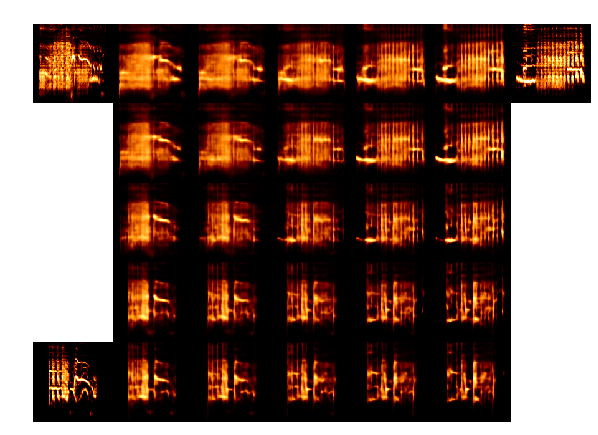

In [123]:
fig, ax = plt.subplots(figsize=(10,10))
ax.matshow(np.squeeze(Jdiagram), vmin = 0, cmap=plt.cm.afmhot, origin = 'lower')
ax.axis('off')
save_fig(FIGURE_DIR / 'networks' / 'starling128'/ ('VAE_JDiagram_128'), dpi=300, save_jpg=True)

In [ ]:
#model.beta = 1

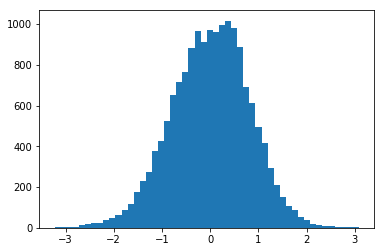

In [99]:
fig, ax = plt.subplots()
z = tf.split(model.enc(example_data), num_or_size_splits=2, axis=1)[0].numpy()
ax.hist(z.flatten(), bins = 50);

In [96]:
np.shape(z)

(128, 128)

In [97]:
xmax, ymax = np.max(z[:,:2], axis=0)
xmin, ymin = np.min(z[:,:2], axis=0)
print(xmax, ymax, xmin, ymin)

2.388661 1.19316 -2.9777195 -2.2834833


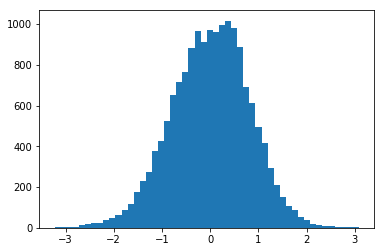

In [ ]:
plot_reconstruction(model, example_data, N_Z)

In [ ]:
RECON = model.reconstruct(example_data)

In [ ]:
np.max(RECON.numpy().flatten())

In [ ]:

# sample from grid
nx = ny =10
meshgrid = np.meshgrid(np.linspace(-3, 3, nx), np.linspace(-3, 3, ny))
meshgrid = np.array(meshgrid).reshape(2, nx*ny).T
x_grid = model.decode(meshgrid)
x_grid = x_grid.numpy().reshape(nx, ny, 28,28, 1)
# fill canvas
canvas = np.zeros((nx*28, ny*28))
for xi in range(nx):
    for yi in range(ny):
        canvas[xi*28:xi*28+28, yi*28:yi*28+28] = x_grid[xi, yi,:,:,:].squeeze()
fig, ax = plt.subplots(figsize=(10,10))
ax.matshow(canvas, cmap=plt.cm.Greys)
ax.axis('off')